# **Import Modules**

In [1]:
import sys

import os

import random as pyrand

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

sys.path.insert(0, '../input/deeplearning-utils')

In [2]:
from utils.ops import plot

from utils.tf.ops import io, eval as tf_eval

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold

from tqdm import tqdm

In [4]:
from kaggle_secrets import UserSecretsClient
from kaggle_datasets import KaggleDatasets

In [5]:
import tensorflow as tf

from tensorflow.keras import backend, optimizers, regularizers

from tensorflow.keras.layers import *

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.callbacks import LearningRateScheduler

# from tensorflow.keras.applications import *

from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_addons as tfa

# **Config**

In [6]:
def set_seed(tf_seed=0, np_seed=0, py_rand=0, py_hash=0):

    os.environ['PYTHONHASHSEED'] = str(py_hash)
    pyrand.seed(py_rand)

    tf.random.set_seed(tf_seed)
    np.random.seed(np_seed)

In [7]:
PATH = {'224': 'cisc22placesandscene224x224'}

In [8]:
class Config:
    
    SEED = 2053
    
    IMAGE_SIZE = (224, 224)

    TRAIN_BATCH_SIZE = 32
    VAL_BATCH_SIZE = 32
        
    SPLIT =10
        
    EPOCHS = 150
    
    TRAINING = True

In [9]:
set_seed(Config.SEED)

In [10]:
try:
    
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    
    print('Running on TPU ', tpu.master())
    
except ValueError:
  
    tpu = None

if tpu is not None:
    
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy(tpu)

else:
    
    strategy = tf.distribute.get_strategy()


print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [11]:
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()

user_secrets.set_tensorflow_credential(user_credential)

GCS_DS_PATH = KaggleDatasets().get_gcs_path(PATH['224'])

In [12]:
augmentations = []

augmentations.append(preprocessing.RandomFlip(mode='horizontal'))
augmentations.append(preprocessing.RandomContrast(factor=0.8))
augmentations.append(preprocessing.RandomRotation(factor=0.1, dtype=tf.float32))

augmentations = Sequential(augmentations)

# **Load Data**

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

In [14]:
train_rec = tf.io.gfile.glob(GCS_DS_PATH + '/train/train/*')

train_rec = np.array(train_rec)

print(len(train_rec))

50


In [15]:
def train_processing(x, y):
        
    x = tf.cast(x, dtype=tf.float32)
    x /= 255.0
        
    y = tf.one_hot(y, depth=6)
    
    return augmentations(x, training=Config.TRAINING), y

In [16]:
def split_generator(train_idx, val_idx):
    
    dtype = {'image': 'bytes', 'label': 'int64'}
    
    reader = io.TfRecordReader(features_dtype=dtype,  image_key='image', 
                               tfrecord_shape=[*Config.IMAGE_SIZE, 3],  
                               shape=None, channels=3,  func=None)
    
    train_data = tf.data.TFRecordDataset(train_rec[train_idx], num_parallel_reads=AUTOTUNE)
    train_data = train_data.with_options(ignore_order)

    train_data = train_data.map(reader.read_tfrecord, num_parallel_calls=AUTOTUNE)
    train_data = train_data.shuffle(512, reshuffle_each_iteration=True)
    train_data = train_data.batch(Config.TRAIN_BATCH_SIZE)
    train_data = train_data.prefetch(AUTOTUNE)
    train_data = train_data.map(train_processing)
    
    val_data = tf.data.TFRecordDataset(train_rec[val_idx], num_parallel_reads=AUTOTUNE)
    val_data = val_data.with_options(ignore_order)

    val_data = val_data.map(reader.read_tfrecord, num_parallel_calls=AUTOTUNE)
    val_data = val_data.batch(Config.VAL_BATCH_SIZE)
    val_data = val_data.prefetch(AUTOTUNE)
    val_data = val_data.map(train_processing)
    
    return train_data, val_data

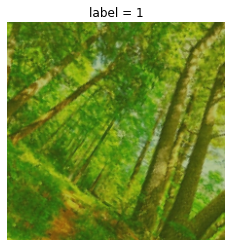

In [17]:
sample_x, sample_y = split_generator(0, 1)[0].unbatch().as_numpy_iterator().next()

plt.imshow(sample_x)
plt.title(f'label = {int(sample_y.argmax())}')
plt.axis('off')
plt.show()

# **Build Model**

In [18]:
input_shape = (*Config.IMAGE_SIZE, 3)

In [19]:
with strategy.scope():
    
    vgg16 =  tf.keras.models.load_model('../input/cisc22buildvgg16/vgg16_places365_no_top.h5', compile=False)
        
    outputs = []
    
    outputs.append(vgg16.get_layer('block2_pool').output)
    outputs.append(vgg16.get_layer('block3_pool').output)
    outputs.append(vgg16.get_layer('block4_pool').output)
    outputs.append(vgg16.get_layer('block5_pool').output)
    
    backbone = Model(vgg16.inputs, outputs)

In [20]:
def build_model():
    
    backbone.trainable = False
    
    # ===================================================================================
    
    inputs = Input(shape=input_shape)
    
    inception = backbone(inputs)
    
    features = []
    
    activation = ['linear', 'relu', 'relu', 'relu']
    
    dropout_rate = [None, None, None, None]
    
    for i in range(len(inception)):
                    
        fi = Conv2D(1024, (1, 1), activation=activation[i])(inception[i])
        fi = Conv2D(1024, (1, 1), activation=activation[i])(fi)
        
        if dropout_rate[i] is not None:
            
            fi = Dropout(dropout_rate[i])(fi)
            
        fi = GlobalAveragePooling2D()(fi)
        
        features.append(fi)
    
    features = Concatenate(axis=-1)(features)
    
    # ===================================================================================

    y_logits = Dense(6, name='y_logits')(features)
    y_proba = Activation('softmax', name='y_proba')(y_logits)
    
    # ===================================================================================

    model = Model(inputs, y_proba)
    
    # ===================================================================================
    
    optimizer = optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)
    
    loss = tf.losses.CategoricalCrossentropy(label_smoothing=0.25, name='categorical_crossentropy')
    metrics = tf.metrics.CategoricalAccuracy(name='accuracy_score')
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    # ===================================================================================

    return model

In [21]:
build_model().summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 56, 56, 128) 14714688    input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 56, 56, 1024) 132096      model[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 1024) 263168      model[0][1]                      
____________________________________________________________________________________________

# **Train Model**

In [22]:
# weights_path = tf.io.gfile.glob('../input/cisc22placesandscenevgg16weights/weights-*.h5')

# print(len(weights_path))

In [23]:
def scheduler(step):
    
    def _scheduler(epoch, lr):
        
        if epoch > 0 and epoch % step == 0:
            
            return max(1e-6, lr * tf.math.exp(-0.75))
        
        else:
            
            return max(1e-6, lr)
    
    return _scheduler

In [24]:
kfold = KFold(n_splits=Config.SPLIT, shuffle=False)

for i, (train_idx, val_idx) in enumerate(kfold.split(train_rec)):
    
    train_data, val_data = split_generator(train_idx, val_idx)
    
    print(f'fold {i} - {"=" * 100}')
    
    with strategy.scope():
        
        model = build_model()
    
#     if i < len(weights_path):
        
#         model.load_weights(weights_path[i])
    
    callbacks = []
    
    callbacks.append(LearningRateScheduler(schedule=scheduler(step=10), verbose=1))
    
    model.fit(train_data, epochs=Config.EPOCHS, validation_data=val_data, callbacks=callbacks)
    
    model.save_weights(f'weights-{i}.h5')
    
    backend.clear_session()
    
    # stop cv
    if i == 0:
        
        break

fold 0 - ====================================================================================================
Epoch 1/150

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
384/384 [==============================] - 107s 247ms/step - loss: 4.0617 - accuracy_score: 0.5135 - val_loss: 1.2645 - val_accuracy_score: 0.7136
Epoch 2/150

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
384/384 [==============================] - 75s 192ms/step - loss: 1.2070 - accuracy_score: 0.7775 - val_loss: 1.1553 - val_accuracy_score: 0.8117
Epoch 3/150

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
384/384 [==============================] - 75s 192ms/step - loss: 1.1505 - accuracy_score: 0.8174 - val_loss: 1.0998 - val_accuracy_score: 0.8557
Epoch 4/150

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
384/384 [==============================] - 75s 193ms/step - los